In [ ]:
# UMAP script to reduce zircon geochemistry
#2024-10-03 MAAZ
#2025-06-26, EBL

# input CG2024 dataset and select parameters (if not already input)
# run UMAP
# create decision boundary - linear SVC
# ROC_AUC curve calculation
# Plot global geochemistry in umap



# Importing libraries and functions

In [1]:
import os
import numpy as np
import pandas as pd
import umap
import umap.plot
# import scipy

import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
import plotly.express as px #for plottly
import joblib #for saving UMAP model

from matplotlib import colors

#Machine learning libraries
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, ShuffleSplit, KFold
from sklearn.metrics import roc_curve, auc, balanced_accuracy_score, f1_score

#Advanced plotting libraries
from itertools import compress
from mpl_toolkits.mplot3d import Axes3D
from bokeh.plotting import output_notebook #for interactive plot

#Script requirements
umap.plot.output_notebook() #resources= INLINE
%matplotlib inline
#%matplotlib widget #for 3d plot
sns.set_theme(style='white', context='notebook', rc={'figure.figsize':(14, 10)}) #anything smaller does not help with points

#Helper functions
def export_legend(legend, filepath2, expand=[-5,-5,5,5]):   

    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    
    fig.savefig(filepath2, dpi="figure", bbox_inches=bbox)

def make_dir(destDir):
    image_dir = destDir
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)  

Loading BokehJS ...

In [9]:
#User input - change directories 
data_folder1 = #SET DIRECTORY HERE!

file1 = "CD2024data_v3.csv"
file2 = "legend.png" #plot
file3 = "workable_table.xlsx" #for reproducibility
file4 = "standard_scaler.xml"
file5 = "umap_model.xml" 

trial_name = 'V3_zircongeochemistry' #IMPORTANT: change this name to avoid overwriting outputs


#Script begins

os.chdir(data_folder1)
print(data_folder1)

data_folder2 = os.path.join(os.path.dirname(data_folder1), 'outputs', trial_name)
make_dir(data_folder2)


filepath1 = os.path.join(data_folder1, file1)
filepath2 = os.path.join(data_folder2, file2)
filepath3 = os.path.join(data_folder2, file3)
filepath4 = os.path.join(data_folder2, file4)
filepath5 = os.path.join(data_folder2, file5)

#Load table (the column indexes below can be obtained from a data dictionary)
table1 = pd.read_csv(filepath1, low_memory=False)
table1.head()

range_imputed = list([0, 1, 2, 5, 6, 9, 10,11, 16, 18, 37,39,22,26,30,35,46,47,49,63])

#range_imputed = list([0, 1, 2, 5, 6, 9, 10,11, 16, 18, 37])
range_imputed.extend(list([19,23,27,36,38,65,66,67,68,69,72,74,75,76,77]))
#range_imputed.extend(range(65, 77)) #imputed REE


#r1
#range_imputed.extend(list([85,90,19,97,39]))

#Generating workable table
table2 = table1.iloc[:, range_imputed] 

#medicine 1
idx1 = table2.Temporality.isnull()
idx2 = table2["DepositBatholith"].isnull()
idx3 = table2["Sample"].isnull()
idx4 = table2["Continent"].isnull()
idx5 = table2["Composition"].isnull()
idx6 = table2["ID"].isnull()
idx7 = table2["District"].isnull()
idx8 = table2["U"].isnull()
idx9 = table2["Ti"].isnull()
idx10 = table2["La"].isnull()
idx11 = table2["Sm"].isnull()
idx12 = table2["Dy"].isnull()
idx13 = table2["Lu"].isnull()
idx14 = table2["Zr"].isnull()
idx15 = table2["Nb"].isnull()
idx16 = table2["Al"].isnull()
idx17 = table2["Zr_Age_Ma"].isnull()


table2.loc[idx1, "Temporality"] = 'Unknown'
table2.loc[idx2, "DepositBatholith"] = 'Unknown'
table2.loc[idx3, "Sample"] = 'Unknown'
table2.loc[idx4, "Continent"] = 'Unknown'
table2.loc[idx5, "Composition"] = 'Unknown'
table2.loc[idx6, "ID"] = 'Unknown'
table2.loc[idx7, "District"] = 'Unknown'
table2.loc[idx8, "U"] = 0
table2.loc[idx9, "Ti"] = 0
table2.loc[idx10, "La"] = 0
table2.loc[idx11, "Sm"] = 0
table2.loc[idx12, "Dy"] = 0
table2.loc[idx13, "Lu"] = 0
table2.loc[idx14, "Zr"] = 0
table2.loc[idx15, "Nb"] = 0
table2.loc[idx16, "Al"] = 0
table2.loc[idx17, "Zr_Age_Ma"] = 0

#Dropping rows with empty cells

#medicine 2: do not drop string NAs
any_idx = table2.isna().any(axis=1)
table3 = table2.loc[np.invert(any_idx), :] # np.invert(any_idx)
table3.reset_index(inplace = True) #the index from the input table is preserved (for searching points)

data_start_idx = 21 #10
col_names = list(table3.columns)
a = table2.shape[0]
b = table3.shape[0]
c = col_names[data_start_idx:]

print(f"Table 2 has {a} rows and Table 3 without NA has {b} rows")
print(f"UMAP will use: {c}")
table3.head()
table3.tail()

C:\Users\n11554070\OneDrive - Queensland University of Technology\Documents\Zircon Geochemistry DB\Test Script 2\v3_zircongeochemistry\trials
Table 2 has 21687 rows and Table 3 without NA has 17172 rows
UMAP will use: ['P', 'Ce', 'Eu', 'Th', 'Hf', 'Imputed_La', 'Imputed_Pr', 'Imputed_Y', 'Imputed_Nd', 'Imputed_Gd', 'Imputed_Er', 'Imputed_Yb', 'Imputed_Sm', 'Imputed_Dy', 'Imputed_Lu']


,index,ml_classes,setID,Dataset,District,DepositBatholith,Temporality,ID,Sample,Composition,...,Imputed_La,Imputed_Pr,Imputed_Y,Imputed_Nd,Imputed_Gd,Imputed_Er,Imputed_Yb,Imputed_Sm,Imputed_Dy,Imputed_Lu
17167,21682,Barren,validation,Unknown,Unknown,Whichita,Unknown,Unknown,WP18-1,Unknown,...,0.575046,1.045060,3837.75999,9.104467,103.12050,485.05126,1020.91950,23.32544,467.87812,100.82260
17168,21683,Barren,validation,Unknown,Unknown,Whichita,Unknown,Unknown,WP18-1,Unknown,...,0.014913,0.413284,2500.79489,6.128216,68.24490,382.16520,925.33635,11.77966,299.00603,97.99182
17169,21684,Barren,validation,Unknown,Unknown,Whichita,Unknown,Unknown,WP18-1,Unknown,...,0.046543,0.182133,2599.79505,4.755513,57.66838,376.21019,798.86338,11.58763,274.47839,98.93058
17170,21685,Barren,validation,Unknown,Unknown,Whichita,Unknown,Unknown,WP18-1,Unknown,...,0.036525,0.181229,2791.75268,5.377526,62.41033,422.80630,952.48400,14.29776,301.63746,100.77420
17171,21686,Barren,validation,Unknown,Unknown,Whichita,Unknown,Unknown,WP18-1,Unknown,...,0.544914,0.503250,3432.46724,9.528770,87.11800,521.75929,1155.45250,20.29084,389.94177,121.44930


# Loading and filtering data

## Printing populations for each category

In [11]:
categoricals = ["ml_classes", "setID", "Dataset", "District", "DepositBatholith", "Temporality", "ID", "Sample", "Composition", "Continent", "Zr_Age_Ma"]
for i in range(len(categoricals)):
    temp = table3.loc[:, [categoricals[i]]].value_counts()
    print(temp)

#table3.loc[:, [categoricals[1]]].value_counts()

ml_classes
Barren        10250
Fertile        6922
Name: count, dtype: int64
setID     
main          15088
validation     2084
Name: count, dtype: int64
Dataset
Deposit    5869
River      4397
GeoRoc     4362
Unknown    2084
Barren      460
Name: count, dtype: int64
District                                   
Unknown                                        10843
Yerington                                       2273
Northwestern Argentina                           952
Eastern Sunda arc Sumbawa                        609
Centinela District                               464
Eocene Wasatch igneous belt Utah                 323
Escondida District                               277
Papua province eastern Indonesia                 259
El Abra-Chuquicamata intrusive cluster           194
S-type Granite                                   172
S-I Granites                                     143
Papua New Guinea                                 129
Central-West New South Wales                     124

# Embedding space
### Run only once each time the notebook is opened. The stochastic process within UMAP wont repeat itself for all plots otherwise

Generating and saving model

In [21]:
# run UMAP IF not using UMAP model and saved scaler from file, if these have been created already, run the cell below instead

try:
    del embedding
except:
    print('Processing for the first time')

components_output = 2 #default=2, dimensionality
neighbors_input = 20 #default=15, preservation of local (> singletons) vs global structure
min_dist_input = 0.003 #0.003, min. dist. of packing value (in low dimensional representation)

#data
data = table3.iloc[:, data_start_idx:].values
sc = StandardScaler()
scaled_data = sc.fit_transform(data) 
#print("Scaler mean: ", sc.mean_)
#print("Scaler scale: ", sc.scale_)

#umap object () for umap.plot
embedding = umap.UMAP(n_neighbors= neighbors_input,
                      min_dist= min_dist_input,
                      metric='correlation', 
                      n_components= components_output,
                     ).fit(scaled_data)  

#Saving data for reproducibility
table3.to_excel(filepath3, index=False) #processed table
joblib.dump(sc, filepath4) #scaler
joblib.dump(embedding, filepath5) #umap transform

['C:\\Users\\n11554070\\OneDrive - Queensland University of Technology\\Documents\\Zircon Geochemistry DB\\outputs\\v3_fish\\umap_model.xml']

In [13]:
# run this IF using the saved scaler and UMAP transform from file, OR after running cell above

sc = joblib.load(filepath4) #scaler
embedding = joblib.load(filepath5) #umap transformation

embedding2 = embedding.embedding_

#Load table 
table3 = pd.read_excel(filepath3)
table3.tail()

,index,ml_classes,setID,Dataset,District,DepositBatholith,Temporality,ID,Sample,Composition,...,Imputed_La,Imputed_Pr,Imputed_Y,Imputed_Nd,Imputed_Gd,Imputed_Er,Imputed_Yb,Imputed_Sm,Imputed_Dy,Imputed_Lu
17167,21682,Barren,validation,Unknown,Unknown,Whichita,Unknown,Unknown,WP18-1,Unknown,...,0.575046,1.045060,3837.75999,9.104467,103.12050,485.05126,1020.91950,23.32544,467.87812,100.82260
17168,21683,Barren,validation,Unknown,Unknown,Whichita,Unknown,Unknown,WP18-1,Unknown,...,0.014913,0.413284,2500.79489,6.128216,68.24490,382.16520,925.33635,11.77966,299.00603,97.99182
17169,21684,Barren,validation,Unknown,Unknown,Whichita,Unknown,Unknown,WP18-1,Unknown,...,0.046543,0.182133,2599.79505,4.755513,57.66838,376.21019,798.86338,11.58763,274.47839,98.93058
17170,21685,Barren,validation,Unknown,Unknown,Whichita,Unknown,Unknown,WP18-1,Unknown,...,0.036525,0.181229,2791.75268,5.377526,62.41033,422.80630,952.48400,14.29776,301.63746,100.77420
17171,21686,Barren,validation,Unknown,Unknown,Whichita,Unknown,Unknown,WP18-1,Unknown,...,0.544914,0.503250,3432.46724,9.528770,87.11800,521.75929,1155.45250,20.29084,389.94177,121.44930


In [15]:
# enter variable below

variable_legend = "District" #e.g., Temporality, ml_classes

list_unique = table3[variable_legend].unique()
n_classes = len(list_unique)

#colourmap
mapping = {item:i for i, item in enumerate(list_unique)}
classif= table3[variable_legend].apply(lambda x: mapping[x]) #categorical array (same size as table3)
colourmap = sns.color_palette(palette= cc.glasbey_category10, n_colors = n_classes)
colours = [sns.color_palette(palette= colourmap)[x] for x in classif] #RGB triplets

colourmap_updated = colourmap #pre-allocating
for x in range(0, n_classes):
    
    idx = (classif == x)
    name = list_unique[x]

    colours_sub = colourmap[x]
    
    if name == 'Ore syn-mineral magmatism':
        colours_sub = colors.to_rgb('red')

    if name == 'Syn Mineral':
        colours_sub = colors.to_rgb('red')

    if name == 'Ore related magmatism':
        target_colour = (255, 208, 0)
        colours_sub = tuple(ti/255 for ti in target_colour)

    if name == 'Unknown':
        colours_sub = colors.to_rgb('lightgrey')

    if name == 'S Type Granite':
        colours_sub = colors.to_rgb('violet')

    colourmap_updated[x] = colours_sub

In [17]:
# enter variable to be used as known labels for binary classification

variable_legend = "ml_classes" #Temporality

#medicine 3
if variable_legend == "Deposit/Batholith":
    variable_legend1 = "Deposit-Batholith"
else:
    variable_legend1 = variable_legend
    

list_unique = table3[variable_legend].unique()
n_classes = len(list_unique)

#colourmap
mapping = {item:i for i, item in enumerate(list_unique)}
classif= table3[variable_legend].apply(lambda x: mapping[x]) #categorical array (same size as table3)

#panda series
df = pd.DataFrame( dict(x=embedding2[:,0], y=embedding2[:,1], z= classif) ) 
X = df.iloc[:, 0:2].to_numpy()
Y = df.iloc[:, 2].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42)
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

In [19]:
# binary decision plane using linear SVC, performance scores of binary model

clf = SVC(kernel="linear", C=0.025, random_state=42, probability= True) #C = 1 (regularisation)

clf.fit(X_train, y_train)
# score = clf.score(X_test, y_test) #mean accuracy 

 # Predict using the best model
best_model = clf #if cross-validation: .best_estimator_
pred = best_model.predict(X_test)
ac = balanced_accuracy_score(y_test, pred) # same as 'score'
f1_ = f1_score(y_test, pred) # F1 scores

# Receiver operating characteristic (ROC) area under the curve (AUC)
probs = best_model.predict_proba(X_test)
probs = probs[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)
auc_ = auc(fpr, tpr)

print("=== Nested K-Fold Cross-Validation Scores ===")
print("Mean balanced accuracy: "+ str(round(np.mean(ac), 3)))
print("Mean F1: "+ str(round(np.mean(f1_), 3)))
print("Mean roc_auc: "+ str(round(np.mean(auc_), 3)))


=== Nested K-Fold Cross-Validation Scores ===
Mean balanced accuracy: 0.647
Mean F1: 0.576
Mean roc_auc: 0.728


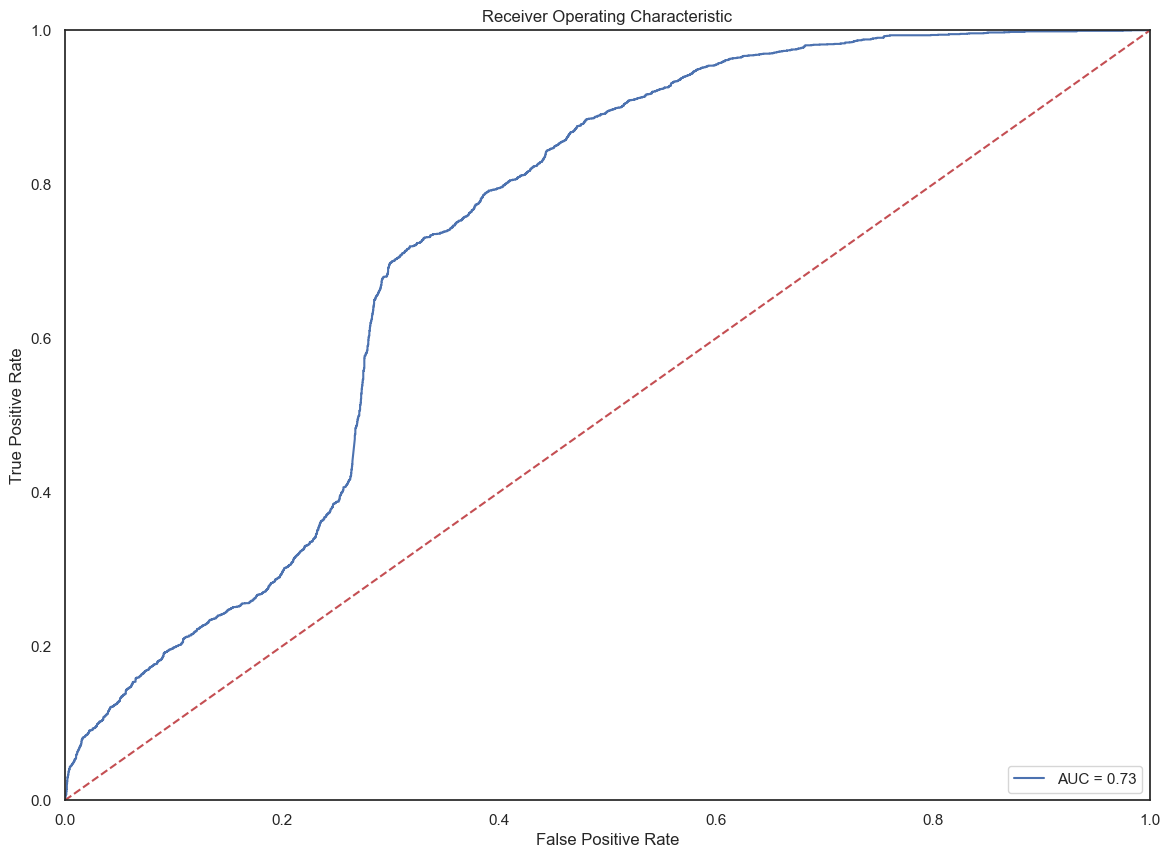

In [21]:
# plotting ROC_AUC

probs = best_model.predict_proba(X_test)
probs = probs[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)
auc_ = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc_)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

C:\Users\n11554070\OneDrive - Queensland University of Technology\Documents\Zircon Geochemistry DB\Test Script 2\v3_zircongeochemistry\outputs\V3_zircongeochemistry\ml_classes_plot.png


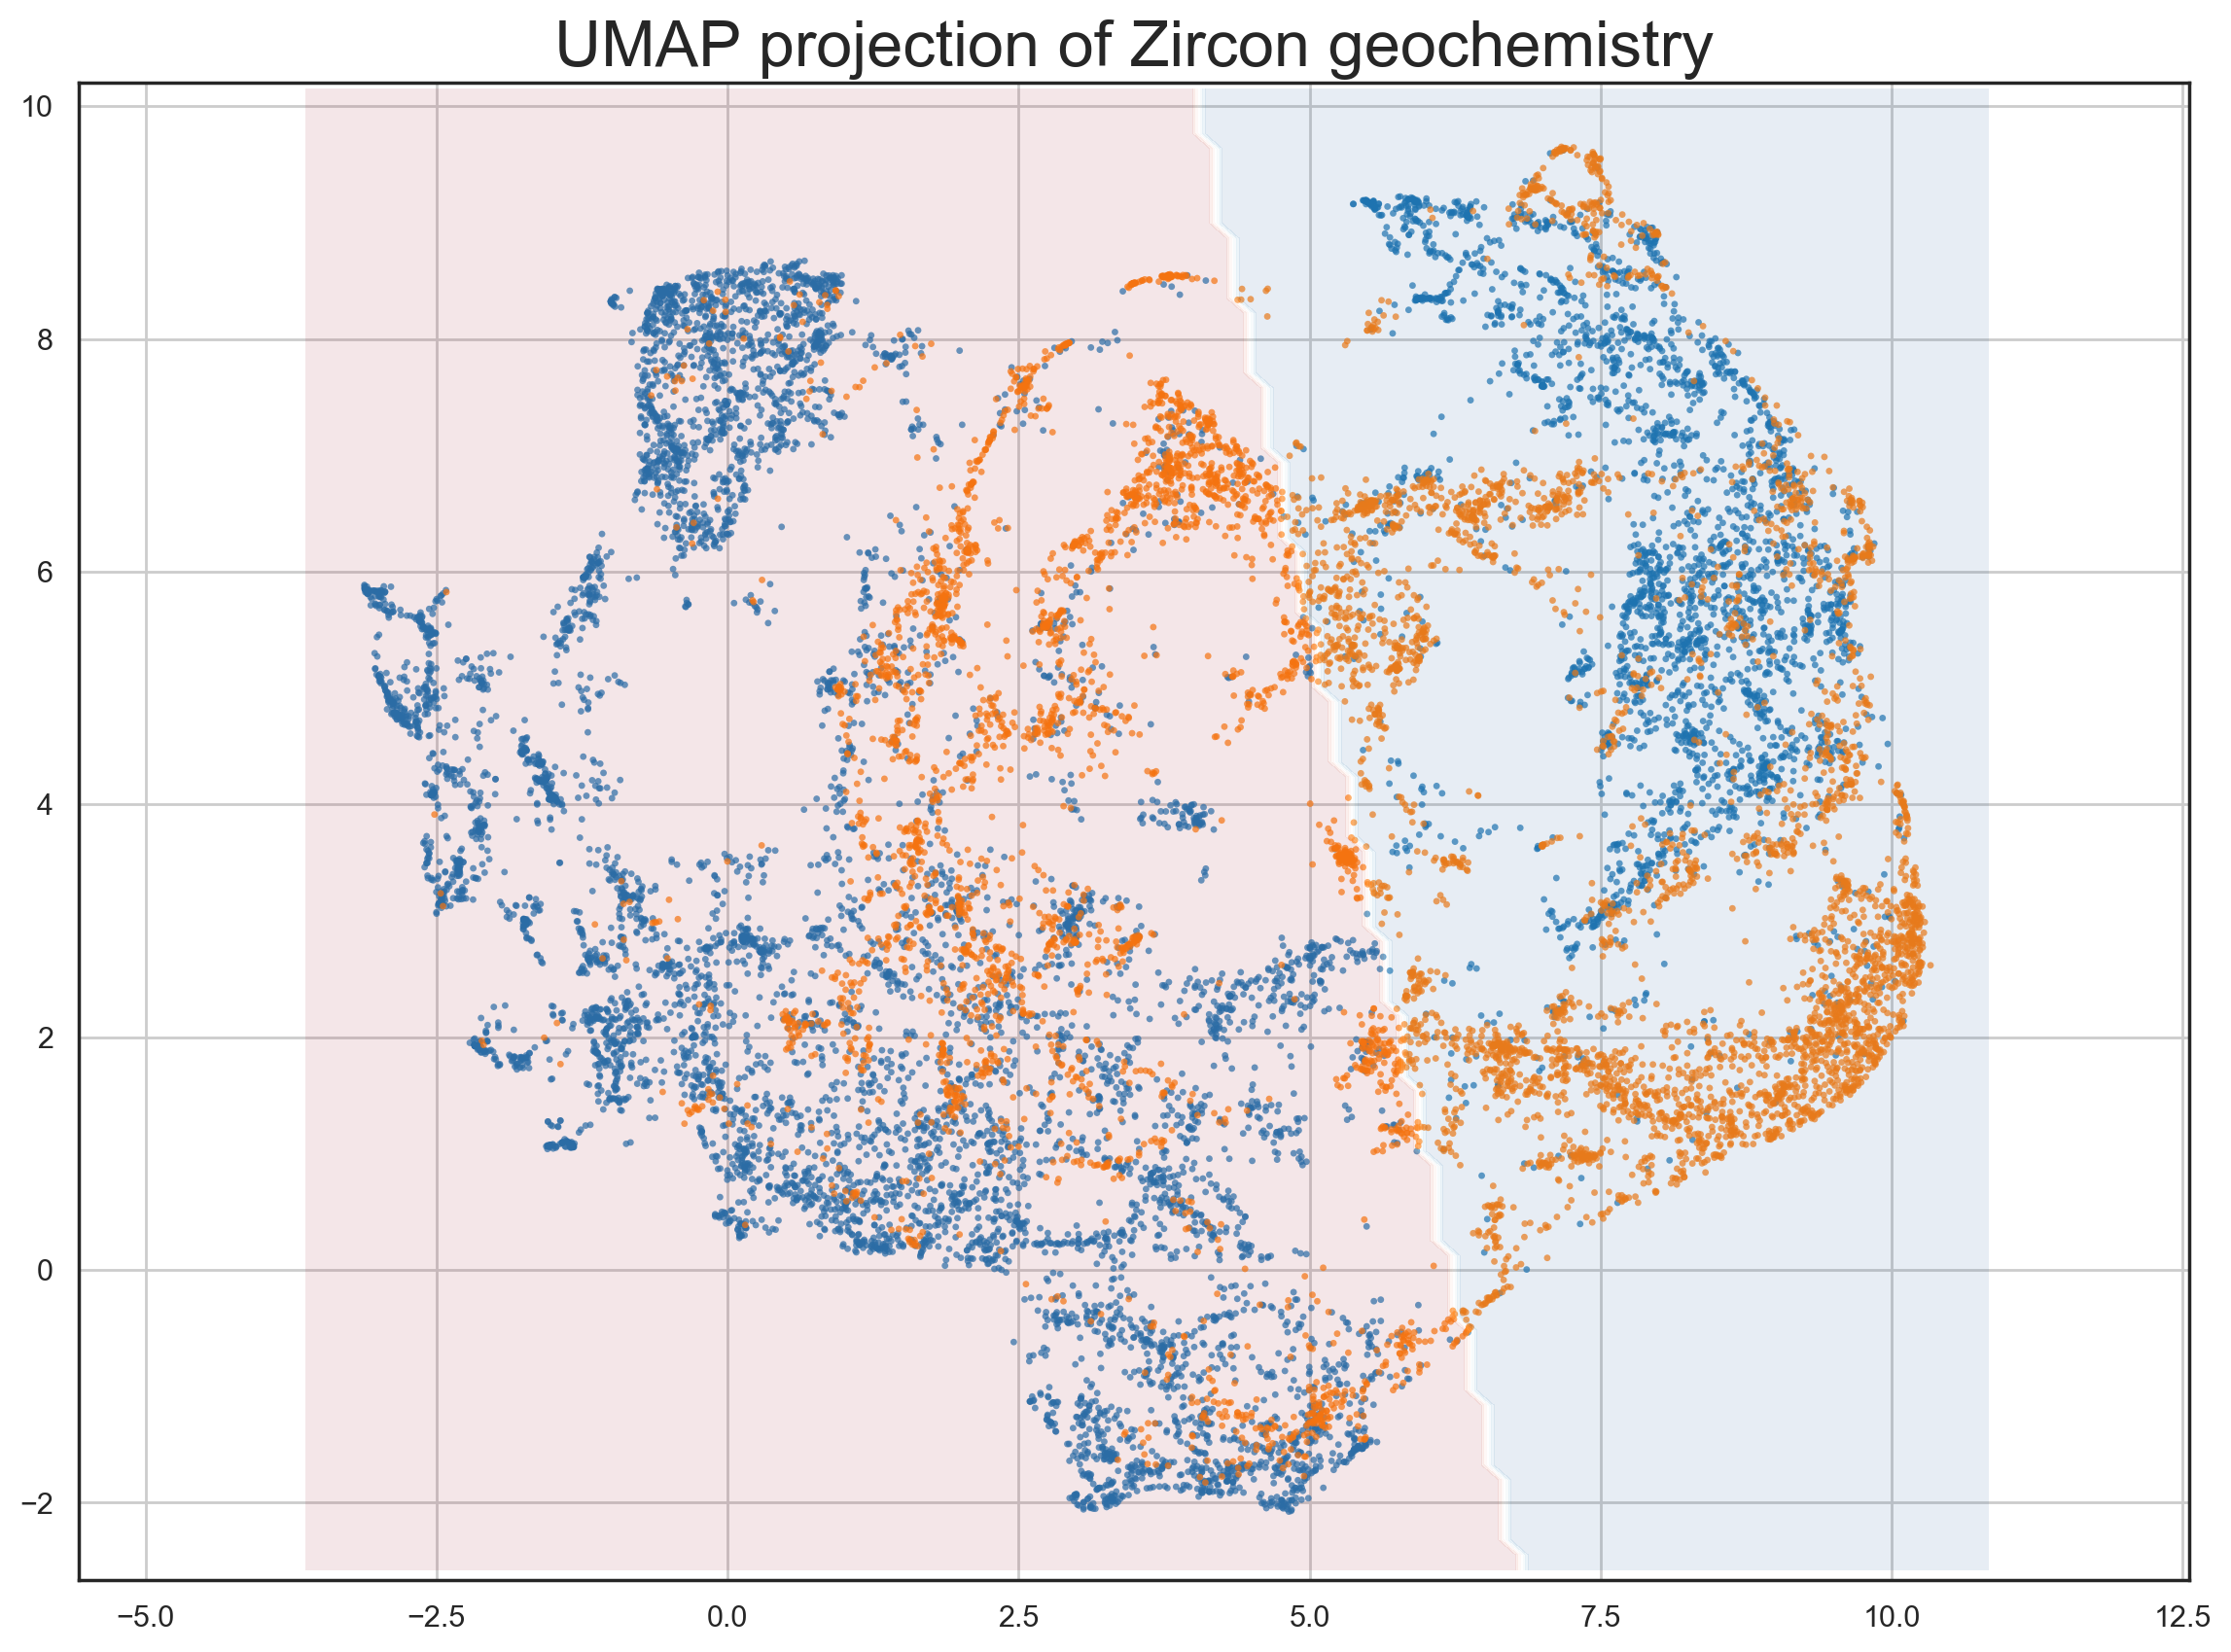

In [27]:
# plot global projection of zircon geochemistry from CG2024

#Saving names
filepath3_new = filepath2.replace("legend.png", variable_legend1 + "_legend.png")
filepath4_new = filepath2.replace("legend.png", variable_legend1 + "_plot.png")
print(filepath4_new)

#Plot
markerSize = 6
fontSize = 18

fig = plt.figure(dpi= 200) #1200 , figsize=(10, 10)

for x in range(0, n_classes):

    
    idx = (classif == x)
    name = list_unique[x]
   
    # colours_sub = list(compress(colours, idx)) #required to index list
    colours_sub = np.asarray(colourmap_updated[x]).reshape(1,-1)        

    scatter = plt.scatter(embedding2[idx, 0], embedding2[idx, 1],
                              c=colours_sub, label = name,
                              s= markerSize, alpha= .7, edgecolors= 'none')


# #Wiggles (new plots)
plt.autoscale(False)
# # plt.plot(xx, yy, 'k-') #linear
# plt.contour(xx, yy, Z, cmap=plt.cm.Paired) #multi-class

#Generic
ax = plt.gca()
cm = plt.cm.RdBu

#Try this 3 options (commenting them if either of them fail)
DecisionBoundaryDisplay.from_estimator(clf, X, cmap=cm, alpha=0.1, ax=ax, eps=.5, response_method='predict') #area with colours following predicted classes (if ignoring 'cm')


#Settings
plt.grid(True)
plt.gca().set_aspect('equal', 'datalim')

plt.title('UMAP projection of Zircon geochemistry', fontsize=24)

lgnd = plt.legend(ncol=1, fontsize= fontSize, loc='center right', bbox_to_anchor=(1.4, 0.5),
                  markerscale= 10, scatterpoints=1)
export_legend(lgnd, filepath2= filepath3_new)
lgnd.remove()
plt.show()

fig.savefig(filepath4_new, dpi="figure")
            